# 画像分類
## 〜 猫と犬の2クラス分類モデルの作成 〜


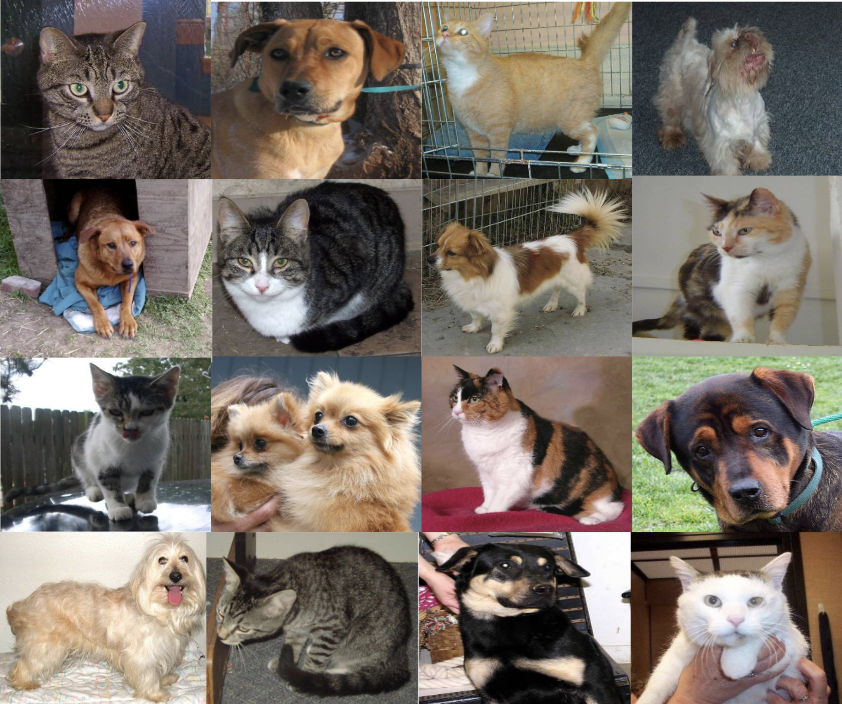

---
## 分類モデルの学習に必要なもの
#### ＜学習環境＞
   * プログラム言語: python
   * 画像処理ライブラリ: opencv
   * 機械学習用フレームワーク: keras     
   * テキストエディタ: jupyter notebook   ...etc
  
  
#### ＜学習データ＞  ※水増し後（水増し前）
* 猫: 2505枚（1255枚） 
    * 訓練データ: 2000枚（1000枚）
    * 検証データ: 500枚（250枚）
    * テストデータ: 5枚 
* 犬: 2505枚（1255枚）
    * 訓練データ: 2000枚（1000枚）
    * 検証データ: 500枚（250枚）
    * テストデータ: 5枚 

※ 訓練(train)データ: モデル自体を学習するためのデータ  
※ 検証(validation)データ: 訓練中に定期的に学習の結果を評価するためのデータ  
※ テスト(test)データ: モデル作成後、モデルの最終的な精度を評価するためのデータ  

---
## 学習手順
#### 1. 学習データの前処理
    * データのリサイズ、正規化
    * データの水増し

  
#### 2. モデルの設計
      

#### 3. ハイパーパラメータの調整
    * 調整することが多いパラメータ
        * epoch（エポック）: 訓練データを繰り返し学習させる回数
        * batch size（バッチサイズ）: 訓練データをサブセットに分けた時のサブセットのデータ数  
        * learning rate（学習率）: 重みの更新幅（大きくしすぎると過学習しやすく、小さくしすぎると誤差の収束に時間がかかる）  
        
  
#### 4. 学習開始

---
## 学習データの前処理用プログラム

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# 画像サイズ
img_size = 80

# 訓練用データセットの水増し設定
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,             # 画像の値を0-1に正規化
    horizontal_flip = True,       # 左右反転: 画像をランダムに左右反転させる (True, False)
    vertical_flip = False,          # 上下反転:　画像をランダムに上下反転させる (True, False)
    rotation_range = 0,          # 回転: 画像を指定した範囲内でランダムに回転させる　（-90~90）
    width_shift_range = 0,    # 水平シフト: 画像を指定した範囲内でランダムに水平移動する (0~1) ← 横幅に対する割合
    height_shift_range = 0,  # 垂直シフト: 画像を指定した範囲内でランダムに垂直移動する (0~1) ← 縦幅に対する割合
    shear_range = 0,              # シアー強度: 画像を指定した範囲内でランダムにシアー変換する (-90~90) 
    zoom_range = 0,             # ズーム: 画像を指定した範囲内でランダムにズームする (0~1) 
)

# 検証用データセットの水増し設定
valid_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    horizontal_flip = True,
    vertical_flip = False, 
    rotation_range = 0,
    width_shift_range = 0,
    height_shift_range = 0,
    shear_range = 0,
    zoom_range = 0
)

# 訓練用データセットの読み込み
train_generator = train_datagen.flow_from_directory(
    'data/train/',                                         # 訓練データセットの格納ディレクトリ
    target_size = (img_size, img_size),  # 80×80にリサイズ
    batch_size = 128,                                # batch sizeの指定
    class_mode = 'categorical')                   

# 検証用データセットの読み込み
validation_generator = valid_datagen.flow_from_directory(
    'data/valid/', 
    target_size = (img_size, img_size),
    batch_size = 128,
    class_mode = 'categorical')

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### ＜おまけ＞ データ拡張(Data Augmentation)後の画像を表示する

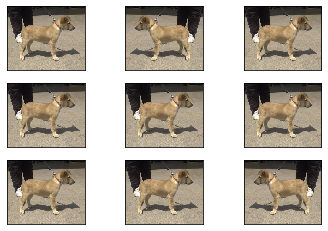

In [3]:
def show_imgs(imgs, row, col):
    if len(imgs) != (row * col):
        raise ValueError("Invalid imgs len:{} col:{} row:{}".format(len(imgs), row, col))

    for i, img in enumerate(imgs):
        # 画像の貼り付け箇所
        plot_num = i + 1
        # サブプロットの作成
        plt.subplot(row, col, plot_num)
        # ラベル, 軸の削除
        plt.tick_params(bottom=False, left=False, right=False, top=False)
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False) 
        # 貼り付け
        plt.imshow(img)
    # 表示
    plt.show()

    
# 画像を読み込み
img = cv2.imread("data/train/dog/dog.348.jpg")
# BGR → RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# 画像をnumpyのndarray形式に変換
x = np.asarray(img)
# # (height, width, 3) -> (1, height, width, 3)
x = x.reshape((1,) + x.shape)

# 表示枚数
max_img_num = 9
# imgsリスト: 水増しした画像を格納するためのリスト
imgs = []

# 水増しした画像をimgsに格納
for d in train_datagen.flow(x, batch_size=1):
    # ndarrayをPIL形式に変換して保存する
    imgs.append(image.array_to_img(d[0], scale=True))
    # 必要な枚数取得できたらループを抜ける
    if (len(imgs) % max_img_num) == 0:
        break
        
# show_imgs関数の呼び出し
show_imgs(imgs, row=3, col=3)


---
## 学習用プログラム

In [4]:
import keras
from keras.layers import Activation, Conv2D, Dense, GlobalAveragePooling2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.optimizers import Adam

In [5]:
# モデルの設計
model = Sequential()

## 1層目
# 畳み込み層 Conv2D(フィルタ数, (フィルタサイズ, フィルタサイズ), activation=活性化関数, input_shape=(入力データサイズ,　入力データサイズ, チャネル数))
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(img_size, img_size, 3)))
# プーリング層 MaxPooling2D((フィルタサイズ, フィルタサイズ))
model.add(MaxPooling2D((2, 2)))

## 2層目
# 畳み込み層
model.add(Conv2D(64, (3, 3), activation="relu"))
# プーリング層
model.add(MaxPooling2D((2, 2)))

## 3層目
# 畳み込み層
model.add(Conv2D(128, (3, 3), activation="relu"))
# プーリング層
model.add(MaxPooling2D((2, 2)))

#  全結合層
model.add(Flatten()) # 1次元に変換
model.add(Dropout(0.5)) # ドロップアウト
model.add(Dense(256, activation="relu")) # 全結合層 256次元
model.add(Dense(2)) # 全結合層 クラス数に合わせる（今回は2クラス分類のため次元数=2）
model.add(Activation('softmax')) # softmax関数

# モデルの構造を出力
model.summary()

W0323 19:02:45.737637 4480648640 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0323 19:02:45.753178 4480648640 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0323 19:02:45.755059 4480648640 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0323 19:02:45.768627 4480648640 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0323 19:02:45.801481 4480648640 deprecation_wrapper.py:119] From //ana

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
__________

In [6]:
## ハイパーパラメータ

# 学習更新回数 epoch = iteration / (データ数 / バッチサイズ)
epochs = 10 
# バッチサイズ
batch_size = 128 
# 学習率
learning_rate = 0.0001

W0323 19:02:45.882819 4480648640 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0323 19:02:45.891451 4480648640 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0323 19:02:45.998551 4480648640 deprecation.py:323] From //anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
32/32 [==============================] - 20s 621ms/step - loss: 0.6906 - acc: 0.5239 - val_loss: 0.6807 - val_acc: 0.6170
Epoch 2/10
32/32 [==============================] - 20s 614ms/step - loss: 0.6749 - acc: 0.5934 - val_loss: 0.6556 - val_acc: 0.6310
Epoch 3/10
32/32 [==============================] - 18s 555ms/step - loss: 0.6461 - acc: 0.6331 - val_loss: 0.6158 - val_acc: 0.6740
Epoch 4/10
32/32 [==============================] - 17s 524ms/step - loss: 0.6337 - acc: 0.6376 - val_loss: 0.6012 - val_acc: 0.6920
Epoch 5/10
32/32 [==============================] - 17s 527ms/step - loss: 0.5953 - acc: 0.6893 - val_loss: 0.5726 - val_acc: 0.7080
Epoch 6/10
32/32 [==============================] - 18s 565ms/step - loss: 0.5797 - acc: 0.6894 - val_loss: 0.5543 - val_acc: 0.7210
Epoch 7/10
32/32 [==============================] - 19s 600ms/step - loss: 0.5548 - acc: 0.7179 - val_loss: 0.5432 - val_acc: 0.7320
Epoch 8/10
32/32 [==============================] - 18s 569ms/step - 

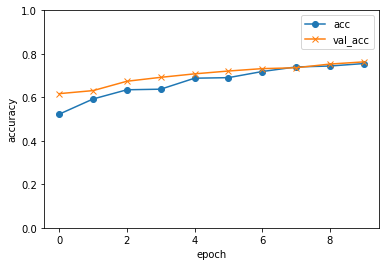

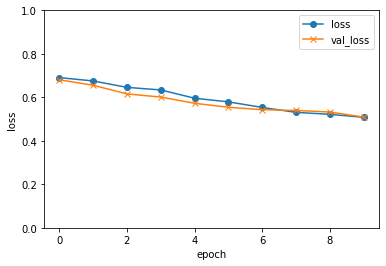

In [7]:
# コンパイル
adam = Adam(learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08) # 最適化手法: Adam
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# 学習
history = model.fit_generator(train_generator,
                                                    steps_per_epoch = len(train_generator) * 2,   # 2倍に水増ししたので×2をする
                                                    validation_data = validation_generator, 
                                                    validation_steps = len(validation_generator) * 2,    # 2倍に水増ししたので×2をする
                                                    epochs = epochs, 
                                                    verbose=1)

# モデルを保存
model.save("model/my_model.h5")

# acc, val_accの図をプロット
plt.plot(history.history["acc"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_acc"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.ylim([0,1])
plt.legend(loc="best")
plt.show()

# loss, val_lossの図をプロット
plt.plot(history.history["loss"], label="loss", ls="-", marker="o")
plt.plot(history.history["val_loss"], label="val_loss", ls="-", marker="x")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.ylim([0,1])
plt.legend(loc="best")
plt.show()

---
## 推論用プログラム
#### 作成したモデルで実際に分類してみましょう！

In [8]:
from keras.models import  load_model
import sys
import glob

>> 予測結果↓
cat: 47.69%
dog: 52.31%

>> この画像は「dog」です。


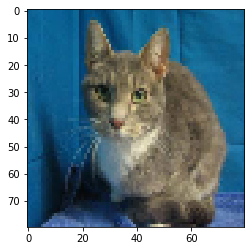

----------------------------------------------------
>> 予測結果↓
cat: 74.39%
dog: 25.61%

>> この画像は「cat」です。


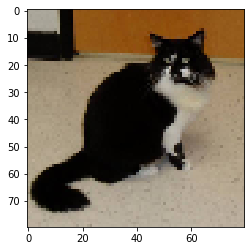

----------------------------------------------------
>> 予測結果↓
cat: 89.76%
dog: 10.24%

>> この画像は「cat」です。


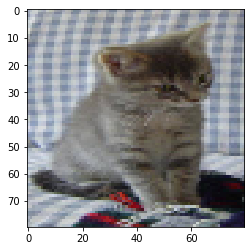

----------------------------------------------------
>> 予測結果↓
cat: 48.23%
dog: 51.77%

>> この画像は「dog」です。


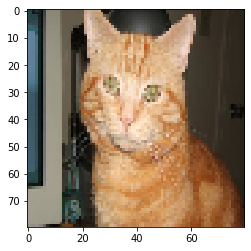

----------------------------------------------------
>> 予測結果↓
cat: 76.17%
dog: 23.83%

>> この画像は「cat」です。


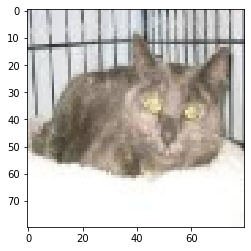

----------------------------------------------------
>> 予測結果↓
cat: 9.06%
dog: 90.94%

>> この画像は「dog」です。


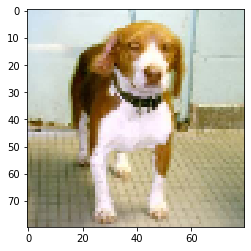

----------------------------------------------------
>> 予測結果↓
cat: 48.98%
dog: 51.02%

>> この画像は「dog」です。


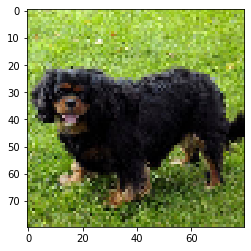

----------------------------------------------------
>> 予測結果↓
cat: 12.16%
dog: 87.84%

>> この画像は「dog」です。


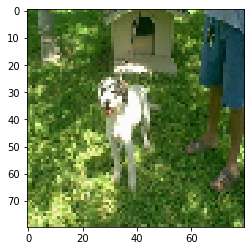

----------------------------------------------------
>> 予測結果↓
cat: 28.06%
dog: 71.94%

>> この画像は「dog」です。


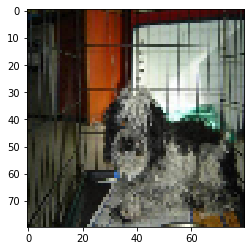

----------------------------------------------------
>> 予測結果↓
cat: 33.15%
dog: 66.85%

>> この画像は「dog」です。


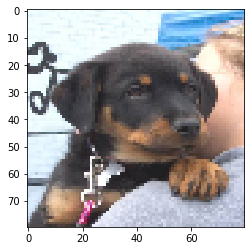

----------------------------------------------------


In [9]:
# クラス名を定義
name = ["cat", "dog"]

# モデルの読み込み
model = load_model('model/my_model.h5')

#　画像ファイルのpathを取得
path = "data/test/"
files = sorted(glob.glob(path + "/*.jpg")) 

#　各画像の形式を変換
for f in files:
    img = cv2.imread(f) #　画像を読み込む
    img = cv2.resize(img, (img_size, img_size)) #　画像を80×80にリサイズ

    # 画像が見つからなかった場合、Not openを出力
    if img is None:
        print("Not open:")
    
    # 画像をモデルが読み込めるように変換
    data = cv2.resize(img, (img_size, img_size))
    x = np.asarray(data)
    x = x.reshape(-1, img_size, img_size, 3)
    x = x.astype("float32") / 255
    # 推論
    pre = model.predict([x])[0]
    idx = pre.argmax()
    # 結果を出力
    print(">> 予測結果↓\n" + name[0] + ": " + str(round(pre[0]*100, 2)) + "%\n" + name[1] + ": " + str(round(pre[1]*100, 2)) + "%\n")
    print(">> この画像は「" + name[idx].replace(",", "") + "」です。")

    # BGR → RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 画像の表示
    plt.imshow(img)
    plt.show()
    print("----------------------------------------------------")

---
## やってみよう


#### データ水増し、ハイパーパラメータ、ネットワーク構造等を変更して、精度を向上してみよう。  

### ☆精度向上のために考えること

#### 【データ】  
・画像サイズを大きくしてみる  
・データを水増しする量を増やしてみる  
・データ水増し手法を変更してみる  
- horizontal_flip       　 ←　左右反転: 画像をランダムに左右反転させる (True, False)
- vertical_flip        　 ←　上下反転:　画像をランダムに上下反転させる (True, False)
- rotation_range      　  ←　回転: 画像を指定した範囲内でランダムに回転させる　（-90~90）
- width_shift_range   　←　水平シフト: 画像を指定した範囲内でランダムに水平移動する (0~1) ← 横幅に対する割合
- height_shift_range  　←　垂直シフト: 画像を指定した範囲内でランダムに垂直移動する (0~1) ← 縦幅に対する割合
- shear_range          　←　シアー強度: 画像を指定した範囲内でランダムにシアー変換する (-90~90) 
- zoom_range          　←　ズーム: 画像を指定した範囲内でランダムにズームする (0~1) 

#### 【ハイパーパラメータ】  
・epochsを増やしてみる  
・batch_sizeを増やしてみる  
・learning rateを調整してみる  

#### 【ネットワーク構造】  
・ネットワークを深くしてみる(層を追加してみる)  